In [37]:
# import the necessary packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output

In [7]:
# load the data
data = pd.read_csv('Sentiment.csv')
print(data.shape)
data.head()

(13871, 21)


,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [8]:
# keep only the necessary columns
data = data[['text', 'sentiment']]
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [9]:
# split the data into train and test set
train, test = train_test_split(data, test_size = 0.1)
# remove neutral sentiments
train = train[train.sentiment != "Neutral"]
print(train.shape)
print(test.shape)

(9646, 2)
(1388, 2)


Positive words


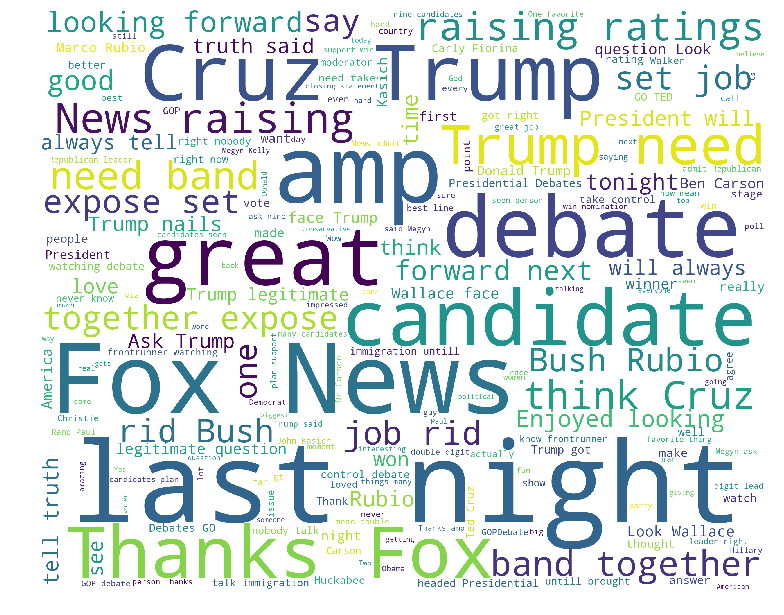

Negative words


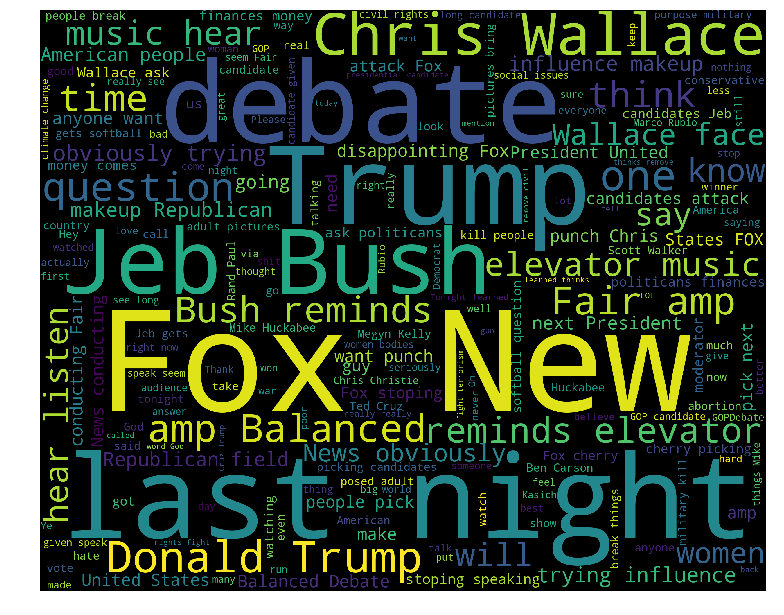

In [18]:
# split positive and negative tweets in order to visualize their contained words
train_pos = train[train.sentiment == 'Positive']
train_pos = train_pos['text']
train_neg = train[train.sentiment == 'Negative']
train_neg = train_neg['text']

# function that create a wordcloud view
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    
    # clean text from hashtags, mentions and links
    cleaned_word = ' '.join([word for word in words.split() 
                            if 'http' not in word 
                            and not word.startswith('@')
                            and not word.startswith('#')
                            and word != 'RT'])
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color=color,
                         width=2500,
                         height=2000).generate(cleaned_word)
    plt.figure(1, figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print('Positive words')
wordcloud_draw(train_pos, 'white')
print('Negative words')
wordcloud_draw(train_neg)

In [19]:
# remove stopwords
tweets = []
stopwords_set = set(stopwords.words('english'))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered if 'http' not in word 
                            and not word.startswith('@')
                            and not word.startswith('#')
                            and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))
    
test_pos = test[test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[test['sentiment'] == 'Negative']
test_neg = test_neg['text']

In [20]:
# extract word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

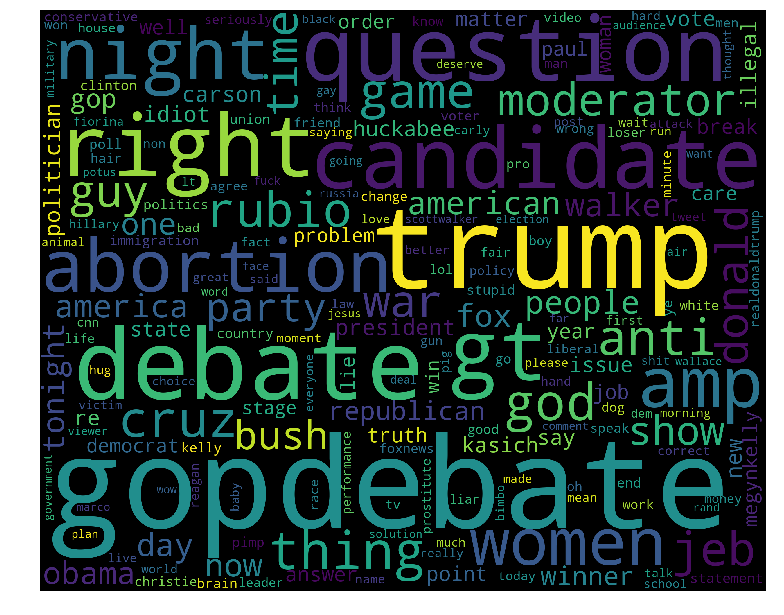

In [27]:
wordcloud_draw(w_features)

In [40]:
# train the Naive Bayes Classifier
training_set = nltk.classify.apply_features(extract_features, tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [41]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))

[Negative]: 875/823 
[Positive]: 208/78 
